**Import Libraries & Load all necessary libraries for data handling and visualization**


In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


**Download and Load Alzheimer’s Dataset**

In [19]:
# This section downloads the Alzheimer’s gene expression dataset from Google Drive using gdown, saves it locally as a CSV file,
# and loads it into a pandas DataFrame for analysis.
#The df.head() command displays the first five rows to verify that the dataset has been loaded correctly.

!pip install gdown

import gdown

file_id = "1geZIouvXrxtrIrNT-hRUInQUeoUOdLSm"
url = f"https://drive.google.com/uc?id={file_id}"

output = "AD-Data.csv"
gdown.download(url, output, quiet=False)

df = pd.read_csv(output)
df.head()

Downloading...
From: https://drive.google.com/uc?id=1geZIouvXrxtrIrNT-hRUInQUeoUOdLSm
To: /content/AD-Data.csv
100%|██████████| 2.00k/2.00k [00:00<00:00, 3.48MB/s]


,Patient,!Sample_title,ID_REF,APP,BACE1,CLU,MAPT,PSEN1,TREM2
0,yes,Severe,GSM21203,2357.1,901.8,3113.2,2288.5,703.9,536.3
1,yes,Incipient,GSM21204,2990.9,870.8,2659.0,1257.0,581.9,408.9
2,yes,Incipient,GSM21205,3255.8,479.6,4685.7,1807.5,526.6,221.8
3,yes,Severe,GSM21206,3091.1,1297.5,14932.1,2268.7,803.8,227.5
4,yes,Severe,GSM21207,2669.9,1073.8,2417.1,1811.9,1000.7,127.5


**Clean and Preprocess Data: Rename columns, set index, ensure gene expression columns are numeric**

In [20]:
# This code preprocesses the dataset by renaming the sample stage column to Stage, ensuring that ID_REF is used as the index for gene identifiers,
# selecting only the genes of interest, and converting their expression values to numeric format for accurate analysis and visualization.
# The first few rows are displayed to verify the changes.

df = df.rename(columns={'!Sample_title': 'Stage'})

if 'ID_REF' not in df.columns:
    df = df.reset_index()

df = df.set_index('ID_REF')

gene_cols = ['APP','BACE1','CLU','MAPT','PSEN1','TREM2']
df[gene_cols] = df[gene_cols].apply(pd.to_numeric)

df.head()


,Patient,Stage,APP,BACE1,CLU,MAPT,PSEN1,TREM2
ID_REF,,,,,,,,
GSM21203,yes,Severe,2357.1,901.8,3113.2,2288.5,703.9,536.3
GSM21204,yes,Incipient,2990.9,870.8,2659.0,1257.0,581.9,408.9
GSM21205,yes,Incipient,3255.8,479.6,4685.7,1807.5,526.6,221.8
GSM21206,yes,Severe,3091.1,1297.5,14932.1,2268.7,803.8,227.5
GSM21207,yes,Severe,2669.9,1073.8,2417.1,1811.9,1000.7,127.5


**Box Plot: Gene Expression by Alzheimer Stage to compare expression levels of all key genes between Severe and Incipient stages.**


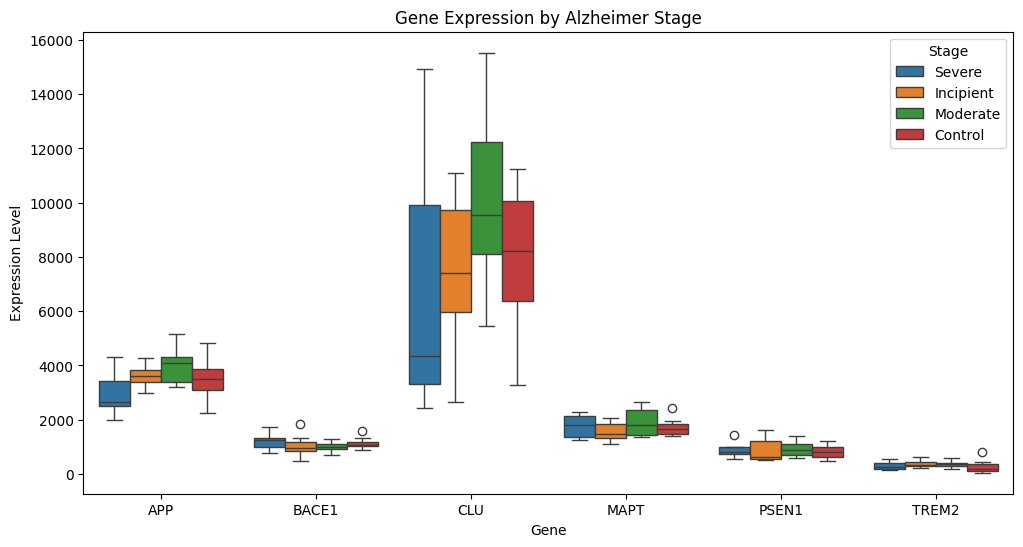

In [21]:
# This code reshapes the dataset from wide to long format using melt so that each gene expression value is in a separate row.
# It then creates a boxplot to visualize the distribution of expression levels for each gene across different Alzheimer stages, adds labels and a title,
# and saves the figure to Google Drive.


df_long = df.reset_index().melt(id_vars=['ID_REF','Stage'],
                                value_vars=['APP','BACE1','CLU','MAPT','PSEN1','TREM2'],
                                var_name='Gene', value_name='Expression')

plt.figure(figsize=(12,6))
sns.boxplot(x='Gene', y='Expression', hue='Stage', data=df_long)
plt.title('Gene Expression by Alzheimer Stage')
plt.xlabel('Gene')
plt.ylabel('Expression Level')
plt.legend(title='Stage')
plt.savefig("gene_expression_boxplot.png", dpi=300, bbox_inches="tight")
plt.show()


**Mean Gene Expression by Stage (Bar Plot with Error Bars)**:

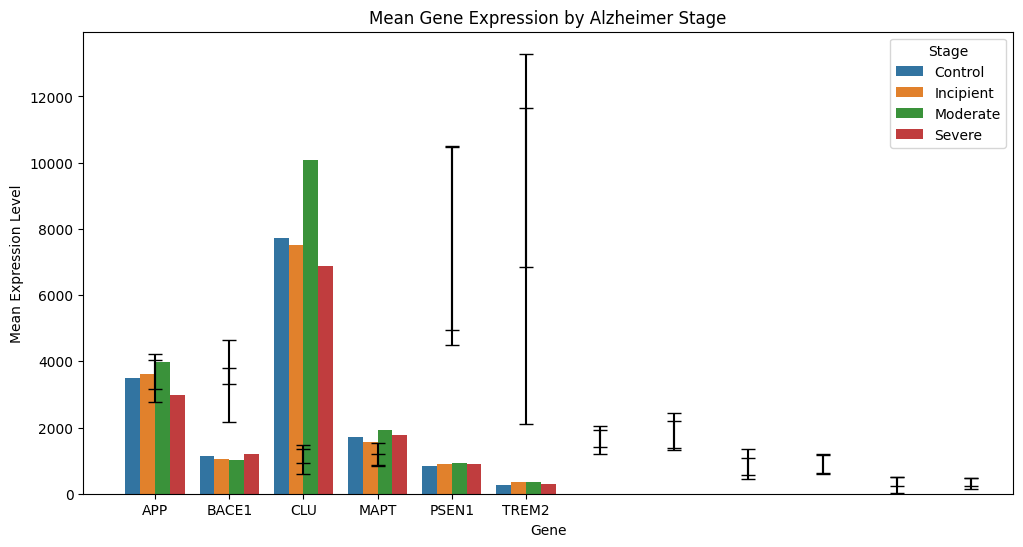

In [22]:
# This code calculates the mean gene expression values for each gene across Alzheimer stages,
# along with the variability (standard deviation). It then creates a bar plot with error bars
# to summarize average expression differences between Incipient and Severe stages and saves
# the figure to Google Drive.


# Calculate mean and standard deviation for each Gene and Stage
df_summary = df_long.groupby(['Gene', 'Stage'])['Expression'].agg(['mean', 'std']).reset_index()

plt.figure(figsize=(12,6))
sns.barplot(x='Gene', y='mean', hue='Stage', data=df_summary, errorbar=None)

# Add error bars manually
for i, row in df_summary.iterrows():
    plt.errorbar( x=i // 2, y=row['mean'], yerr=row['std'],fmt='none',capsize=5, color='black')

plt.title('Mean Gene Expression by Alzheimer Stage')
plt.xlabel('Gene')
plt.ylabel('Mean Expression Level')
plt.legend(title='Stage')
plt.savefig("mean_gene_expression_barplot.png", dpi=300, bbox_inches="tight")
plt.show()


**Heatmap of Differentially Expressed Genes to visualize overall gene expression patterns across samples, highlighting up- and down-regulated genes.**

In [23]:
# This code calculates the mean expression of each gene for every Alzheimer stage, computes the fold change between Severe and Incipient stages,
# and sorts the genes in descending order  of fold change to identify those with the largest differences in expression

gene_means = df.groupby('Stage')[['APP','BACE1','CLU','MAPT','PSEN1','TREM2']].mean()


fold_change = gene_means.loc['Severe'] / gene_means.loc['Incipient']
print("Fold change (Severe / Incipient):\n", fold_change)


sorted_genes = fold_change.sort_values(ascending=False).index.tolist()



Fold change (Severe / Incipient):
 APP      0.823224
BACE1    1.149670
CLU      0.916792
MAPT     1.123004
PSEN1    0.985029
TREM2    0.823637
dtype: float64


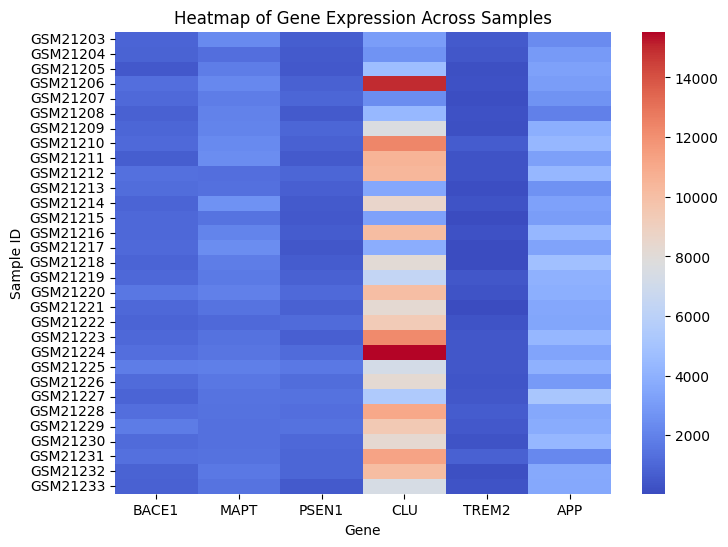

In [24]:
# This part generates a heatmap of gene expression for the selected genes (sorted by fold change) across all samples.
# The heatmap uses a color gradient to represent expression levels, with labels for genes and samples,
# and the figure is saved to Google Drive.

plt.figure(figsize=(8,6))
sns.heatmap(df[sorted_genes], cmap='coolwarm', annot=False)
plt.title('Heatmap of Gene Expression Across Samples')
plt.ylabel('Sample ID')
plt.xlabel('Gene')
plt.savefig("heatmap.png", dpi=300, bbox_inches="tight")
plt.show()

**Table of Significant Genes to list genes with largest expression differences, including mean values and fold-change.**




In [25]:
# This code separates the dataset into two subsets based on Alzheimer stage, creating one DataFrame for Severe samples and another for Incipient samples.
# Only the genes of interest are considered for further analysis.

gene_cols = ['APP','BACE1','CLU','MAPT','PSEN1','TREM2']

severe = df[df['Stage']=='Severe']
incipient = df[df['Stage']=='Incipient']



In [26]:
# This code iterates over the selected genes, calculates the mean expression for Severe and Incipient samples, computes the fold change
# between the two stages for each gene, and stores the results in a list of dictionaries for further analysis.


results = []

for gene in gene_cols:
    mean_severe = severe[gene].mean()
    mean_incipient = incipient[gene].mean()
    fold_change = mean_severe / mean_incipient

    results.append({
        'Gene': gene,
        'Mean_Severe': mean_severe,
        'Mean_Incipient': mean_incipient,
        'Fold_Change': fold_change
    })

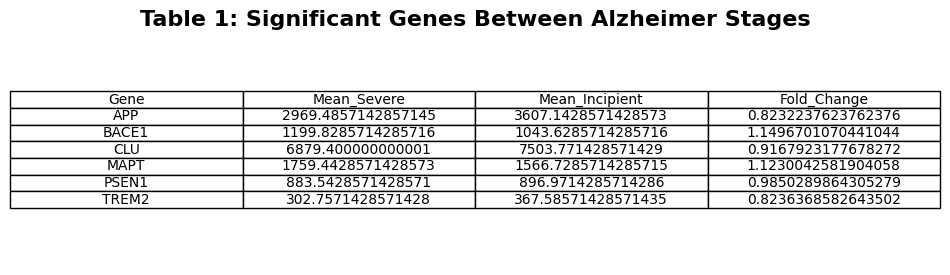

In [27]:
# This part of the code creates a visual table of the significant genes by converting the sig_genes_df DataFrame into a matplotlib table. Axes are hidden, a title is added,
# and the figure is saved to Google Drive for presentation purposes.

results_df = pd.DataFrame(results)
sig_genes_df = results_df
plt.figure(figsize=(12, len(sig_genes_df)*0.5))

plt.axis('off')

plt.table(cellText=sig_genes_df.values,
          colLabels=sig_genes_df.columns,
          cellLoc='center',
          loc='center')
plt.title("Table 1: Significant Genes Between Alzheimer Stages", fontsize=16, fontweight='bold')

plt.savefig("sig_genes_table.png", dpi=300, bbox_inches="tight")
plt.show()


**Fold-Change Bar Plot (Severe vs Incipient)**

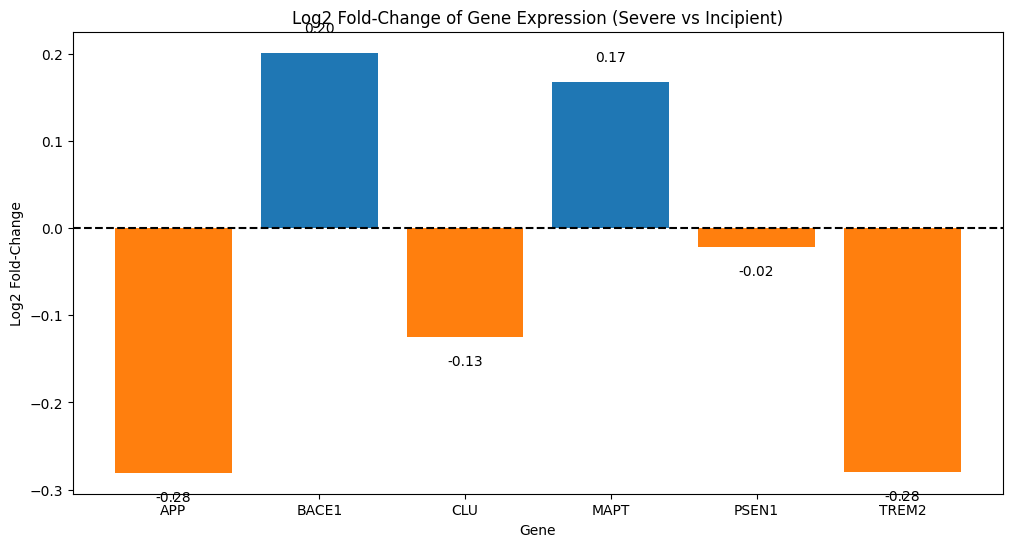

In [28]:
# This code calculates the log2 fold-change in gene expression between Severe and Incipient Alzheimer’s stages.
# It creates a bar plot with custom colors matching the box plot, displays fold-change values on top of bars,
# adds labels and a title, and saves the figure to the working directory.


# Calculate mean expression for each gene in each stage
mean_expr = df_long.groupby(['Gene', 'Stage'])['Expression'].mean().reset_index()

# Pivot table to have Incipient and Severe columns
mean_expr_pivot = mean_expr.pivot(index='Gene', columns='Stage', values='Expression').reset_index()

# Calculate log2 fold-change: log2(Severe / Incipient)
mean_expr_pivot['log2FC'] = np.log2(mean_expr_pivot['Severe'] / mean_expr_pivot['Incipient'])

bar_colors = ['#1f77b4' if x > 0 else '#ff7f0e' for x in mean_expr_pivot['log2FC']]

plt.figure(figsize=(12,6))
bars = plt.bar(mean_expr_pivot['Gene'], mean_expr_pivot['log2FC'], color=bar_colors)

# Add a horizontal line at y=0 for reference
plt.axhline(0, color='black', linestyle='--')

# Add fold-change values on top of each bar
for bar in bars:
    yval = bar.get_height()
    plt.text( bar.get_x() + bar.get_width()/2, yval + 0.02*np.sign(yval), f'{yval:.2f}', ha='center', va='bottom' if yval>=0 else 'top')

plt.title('Log2 Fold-Change of Gene Expression (Severe vs Incipient)')
plt.xlabel('Gene')
plt.ylabel('Log2 Fold-Change')
plt.savefig("fold_change_barplot.png", dpi=300, bbox_inches="tight")
plt.show()


**Histogram / Distribution Plot of Gene Expression to show the distribution of expression levels across all samples for each gene.**

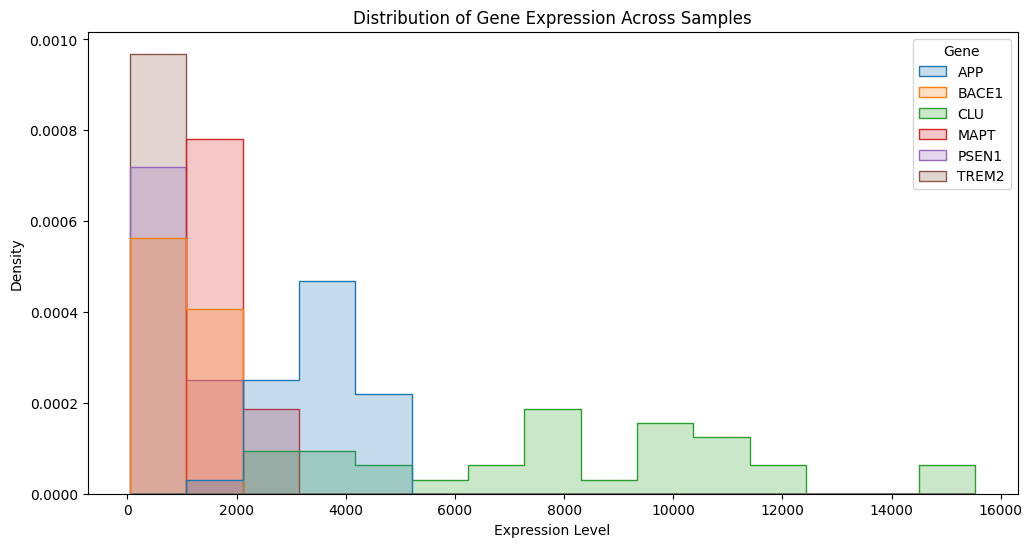

In [29]:
# This code reshapes the dataset to long format and creates a histogram to visualize the distribution of expression levels for each gene across all samples.
# The histogram is color-coded by gene, normalized to show density, and the resulting figure is saved to Google Drive.

df_long = df.reset_index().melt(id_vars=['ID_REF','Stage'],
                                value_vars=['APP','BACE1','CLU','MAPT','PSEN1','TREM2'],
                                var_name='Gene', value_name='Expression')

plt.figure(figsize=(12,6))
sns.histplot(data=df_long, x='Expression', hue='Gene', element='step', stat='density', common_norm=False, bins=15)
plt.title("Distribution of Gene Expression Across Samples")
plt.xlabel("Expression Level")
plt.ylabel("Density")
plt.savefig("distribution_gene_expression_hist.png", dpi=300, bbox_inches="tight")
plt.show()